In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import dask
from dask.distributed import Client, SSHCluster
import dask.distributed

# import hvplot.dask

In [2]:
import glob
dir_path = '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_*'
dir_list = glob.glob(dir_path)
print(len(dir_list))

60


In [3]:
# def preprocessing_bag_of_thread(bag_of_thread):  #bag of bag

def preprocessing_bag_of_thread(paths):
    
    output_column_to_read = ['name', 'Mass_0', 'RemnantType_0', 'Mass_1', 'RemnantType_1',
                         'Semimajor','Eccentricity','GWtime','BWorldtime']

    output_column_type = ['string', 'float64', 'int64', 'float64', 'int64',
                      'float64', 'float64', 'float64', 'float64', 'int64']

    evolved_column_to_read = ['name', 'Mass_0', 'Z_0', 'SN_0', 'Mass_1', 'SN_1', 'a', 'e']


    evolved_column_type = ['string', 'float64', 'float64', 'string', 'float64', 
                      'string', 'float64', 'float64']

    drop_list = ['RemnantType_0',  'RemnantType_1']
    
    # decomment if you want the bag of bag
   # paths = bag_of_thread.take(3)

   
    #preprocessing output
    
    output = pd.read_csv(paths[0], usecols=output_column_to_read, dtype=dict(zip(output_column_to_read, output_column_type))).\
                rename(columns={'Mass_0':'Mass_0_out', 'Mass_1':'Mass_1_out'})

    idxBHBH=(output.RemnantType_0==6) & (output.RemnantType_1==6) & (output.Semimajor.notnull())
    output=output[idxBHBH]
    
    df=output
    
    
    #preprocessing evolved
    
    alpha = float(re.findall(r".+(?<=A)(.*)(?=L)", paths[1])[0])
    
    evolved = pd.read_table(paths[1], sep='\s+', usecols=evolved_column_to_read, dtype=dict(zip(evolved_column_to_read, evolved_column_type)))                
    
    evolved['alpha'] = alpha
    
    #preprocessing logfile
    
    logfile = pd.read_csv(paths[2], header=None)

    df_RLO = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);RLO_BEGIN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='RLO').\
                reset_index()

    df_CE = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);CE;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='CE').\
                reset_index()

    df_BSN = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);BSN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='BSN').\
                reset_index()

    
    #merge
    bhbh = evolved.merge(output, on=['name'], how='inner').\
                   merge(df_RLO, on=['name'], how='left').\
                   merge(df_CE,  on=['name'], how='left').\
                   merge(df_BSN, on=['name'], how='left').\
                   fillna(value=0).\
                   drop(columns=drop_list)
    
    #add some useful columns
    bhbh['tdelay'] = bhbh['GWtime'] + bhbh['BWorldtime']

    bhbh['Mass_max_out'] = bhbh['Mass_1_out']
    bhbh['Mass_max_out'] = bhbh['Mass_max_out'].\
                            where(cond=(bhbh['Mass_max_out'] > bhbh['Mass_0_out']), other=bhbh['Mass_0_out'])

    bhbh['q'] = bhbh['Mass_1_out']/bhbh['Mass_0_out']
    bhbh['q'] = bhbh['q'].\
                where(cond=(bhbh['Mass_1_out'] < bhbh['Mass_0_out']), other=bhbh['Mass_0_out']/bhbh['Mass_1_out'])

    bhbh['Mass_chirp'] = ((bhbh['Mass_0_out'] * bhbh['Mass_1_out'])**(3/5))/((bhbh['Mass_0_out'] + bhbh['Mass_1_out'])**(1/5))
    
    return bhbh

In [4]:
#cluster up
cluster = SSHCluster(
["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
worker_options={"n_workers": 4,
                "nthreads": 4}, # because each bhbh-* has 4 cores
scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )
client=Client(cluster)

2023-06-20 15:29:49,362 - distributed.deploy.ssh - INFO - 2023-06-20 15:29:49,360 - distributed.scheduler - INFO - State start
2023-06-20 15:29:49,369 - distributed.deploy.ssh - INFO - 2023-06-20 15:29:49,368 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-20 15:29:50,417 - distributed.deploy.ssh - INFO - 2023-06-20 15:29:50,416 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:37819'
2023-06-20 15:29:50,435 - distributed.deploy.ssh - INFO - 2023-06-20 15:29:50,434 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:37279'
2023-06-20 15:29:50,440 - distributed.deploy.ssh - INFO - 2023-06-20 15:29:50,438 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:39695'
2023-06-20 15:29:50,445 - distributed.deploy.ssh - INFO - 2023-06-20 15:29:50,445 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43161'
2023-06-20 15:29:51,603 - distributed.deploy.ssh - INFO - 2023-06-20

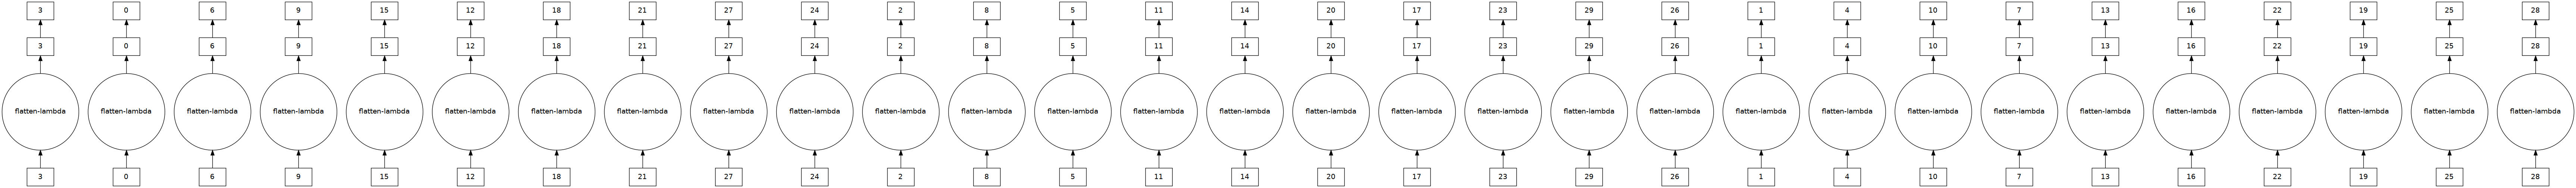

In [28]:
bag=db.from_sequence([
                        [dir_ + f'/0/output_{thread}.csv', 
                         dir_ + f'/0/evolved_{thread}.dat',
                         dir_ + f'/0/logfile_{thread}.dat'] for dir_ in [dir_list[0]] for thread in range(30)], npartitions= 30)
            
## Map the preprocessing function to the bag
bag_of_df = bag.map(preprocessing_bag_of_thread)
dask.visualize(bag_of_df, filename='bag_of_df_30.png')

bag_of_dicts = bag_of_df.map(lambda df: df.to_dict(orient='records')).flatten()
bhbh = bag_of_dicts.to_dataframe()

#bhbh.visualize(filename='bhbhb_bag_15.png')
#dask.visualize(bhbh, filename='bag_visualize.png')
bhbh.visualize(filename='bhbhb_bag_30.png')

# Benchmark Workers Threads

In [ ]:
attempt = 10
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
time_list = np.zeros(shape=(attempt, len(workers_list), len(threads_list)))

for a in range(attempt):
    for w,_ in enumerate(workers_list):
        for t,_ in enumerate(threads_list):
            print('a:', a, '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
            #cluster up
            cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": workers_list[w],
                            "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
            client=Client(cluster)

            #begin time
            time_i = time.time()
            
            bag=db.from_sequence([
                        [dir_ + f'/0/output_{thread}.csv', 
                         dir_ + f'/0/evolved_{thread}.dat',
                         dir_ + f'/0/logfile_{thread}.dat'] for dir_ in [dir_list[0]] for thread in range(30)])
            
            ## Map the preprocessing function to the bag
            bag_of_df = bag.map(preprocessing_bag_of_thread)
            
            
            bag_of_dicts = bag_of_df.map(lambda df: df.to_dict(orient='records')).flatten()
            bhbh=bag_of_dicts.to_dataframe()#.repartition(npartitions=4)
            bhbh = bhbh.compute()
            
            #end time
            time_f = time.time()
            
            #time difference allocation
            time_list[a, w, t] = time_f - time_i

            #cluster down
            cluster.close()
            
#Save the result
np.save('Bench_files_10/Benchmark_Workers_Threads_bag_try_10.npy', time_list)

a: 0 	 w: 1 	 t: 1


2023-06-17 05:32:52,326 - distributed.deploy.ssh - INFO - 2023-06-17 05:32:52,325 - distributed.scheduler - INFO - State start
2023-06-17 05:32:52,334 - distributed.deploy.ssh - INFO - 2023-06-17 05:32:52,327 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qhxpze0x', purging
2023-06-17 05:32:52,335 - distributed.deploy.ssh - INFO - 2023-06-17 05:32:52,329 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4v5o13j8', purging
2023-06-17 05:32:52,336 - distributed.deploy.ssh - INFO - 2023-06-17 05:32:52,330 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-px9bfatq', purging
2023-06-17 05:32:52,338 - distributed.deploy.ssh - INFO - 2023-06-17 05:32:52,331 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-io1aoaeo', purging
2023-06-17 05:32:52,341 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 w: 1 	 t: 2


2023-06-17 05:40:20,639 - distributed.deploy.ssh - INFO - 2023-06-17 05:40:20,637 - distributed.scheduler - INFO - State start
2023-06-17 05:40:20,643 - distributed.deploy.ssh - INFO - 2023-06-17 05:40:20,639 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qsaosvwx', purging
2023-06-17 05:40:20,646 - distributed.deploy.ssh - INFO - 2023-06-17 05:40:20,645 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 05:40:21,611 - distributed.deploy.ssh - INFO - 2023-06-17 05:40:21,609 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35217'
2023-06-17 05:40:22,420 - distributed.deploy.ssh - INFO - 2023-06-17 05:40:22,418 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:40409
2023-06-17 05:40:23,818 - distributed.deploy.ssh - INFO - 2023-06-17 05:40:23,819 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:35483'
2023-06-17 05:40:23,980 - dis

a: 0 	 w: 1 	 t: 4


2023-06-17 05:45:42,044 - distributed.deploy.ssh - INFO - 2023-06-17 05:45:42,042 - distributed.scheduler - INFO - State start
2023-06-17 05:45:42,049 - distributed.deploy.ssh - INFO - 2023-06-17 05:45:42,044 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4t27aza7', purging
2023-06-17 05:45:42,053 - distributed.deploy.ssh - INFO - 2023-06-17 05:45:42,052 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 05:45:42,980 - distributed.deploy.ssh - INFO - 2023-06-17 05:45:42,978 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:39315'
2023-06-17 05:45:43,824 - distributed.deploy.ssh - INFO - 2023-06-17 05:45:43,822 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:43599
2023-06-17 05:45:45,304 - distributed.deploy.ssh - INFO - 2023-06-17 05:45:45,305 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:43279'
2023-06-17 05:45:45,664 - dis

a: 0 	 w: 2 	 t: 1


2023-06-17 05:50:10,165 - distributed.deploy.ssh - INFO - 2023-06-17 05:50:10,164 - distributed.scheduler - INFO - State start
2023-06-17 05:50:10,168 - distributed.deploy.ssh - INFO - 2023-06-17 05:50:10,166 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-25gl31vb', purging
2023-06-17 05:50:10,174 - distributed.deploy.ssh - INFO - 2023-06-17 05:50:10,174 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 05:50:11,104 - distributed.deploy.ssh - INFO - 2023-06-17 05:50:11,103 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:46181'
2023-06-17 05:50:11,373 - distributed.deploy.ssh - INFO - 2023-06-17 05:50:11,372 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:40931'
2023-06-17 05:50:12,161 - distributed.deploy.ssh - INFO - 2023-06-17 05:50:12,159 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:38379
2023-06-17 05:50:12,162 - di

a: 0 	 w: 2 	 t: 2


2023-06-17 05:55:00,728 - distributed.deploy.ssh - INFO - 2023-06-17 05:55:00,726 - distributed.scheduler - INFO - State start
2023-06-17 05:55:00,731 - distributed.deploy.ssh - INFO - 2023-06-17 05:55:00,728 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-blq0epgl', purging
2023-06-17 05:55:00,732 - distributed.deploy.ssh - INFO - 2023-06-17 05:55:00,731 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ucxf4ft1', purging
2023-06-17 05:55:00,739 - distributed.deploy.ssh - INFO - 2023-06-17 05:55:00,738 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 05:55:01,639 - distributed.deploy.ssh - INFO - 2023-06-17 05:55:01,638 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45275'
2023-06-17 05:55:01,657 - distributed.deploy.ssh - INFO - 2023-06-17 05:55:01,655 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 0 	 w: 2 	 t: 4


2023-06-17 05:59:23,279 - distributed.deploy.ssh - INFO - 2023-06-17 05:59:23,276 - distributed.scheduler - INFO - State start
2023-06-17 05:59:23,283 - distributed.deploy.ssh - INFO - 2023-06-17 05:59:23,278 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gyp1eakz', purging
2023-06-17 05:59:23,284 - distributed.deploy.ssh - INFO - 2023-06-17 05:59:23,279 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-d9ml3qm8', purging
2023-06-17 05:59:23,289 - distributed.deploy.ssh - INFO - 2023-06-17 05:59:23,288 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 05:59:24,271 - distributed.deploy.ssh - INFO - 2023-06-17 05:59:24,270 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43003'
2023-06-17 05:59:24,651 - distributed.deploy.ssh - INFO - 2023-06-17 05:59:24,650 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 0 	 w: 4 	 t: 1


2023-06-17 06:03:15,933 - distributed.deploy.ssh - INFO - 2023-06-17 06:03:15,931 - distributed.scheduler - INFO - State start
2023-06-17 06:03:15,936 - distributed.deploy.ssh - INFO - 2023-06-17 06:03:15,933 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xsof8yly', purging
2023-06-17 06:03:15,937 - distributed.deploy.ssh - INFO - 2023-06-17 06:03:15,934 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-vjeyusqn', purging
2023-06-17 06:03:15,940 - distributed.deploy.ssh - INFO - 2023-06-17 06:03:15,939 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 06:03:16,948 - distributed.deploy.ssh - INFO - 2023-06-17 06:03:16,946 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43081'
2023-06-17 06:03:16,972 - distributed.deploy.ssh - INFO - 2023-06-17 06:03:16,972 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 0 	 w: 4 	 t: 2


2023-06-17 06:06:42,604 - distributed.deploy.ssh - INFO - 2023-06-17 06:06:42,603 - distributed.scheduler - INFO - State start
2023-06-17 06:06:42,611 - distributed.deploy.ssh - INFO - 2023-06-17 06:06:42,605 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6q2kfwwd', purging
2023-06-17 06:06:42,613 - distributed.deploy.ssh - INFO - 2023-06-17 06:06:42,606 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h4em2ssd', purging
2023-06-17 06:06:42,614 - distributed.deploy.ssh - INFO - 2023-06-17 06:06:42,610 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dpu5j3q6', purging
2023-06-17 06:06:42,617 - distributed.deploy.ssh - INFO - 2023-06-17 06:06:42,616 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-cqsse44b', purging
2023-06-17 06:06:42,624 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 w: 4 	 t: 4


2023-06-17 06:09:57,880 - distributed.deploy.ssh - INFO - 2023-06-17 06:09:57,878 - distributed.scheduler - INFO - State start
2023-06-17 06:09:57,897 - distributed.deploy.ssh - INFO - 2023-06-17 06:09:57,889 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7xm2963s', purging
2023-06-17 06:09:57,903 - distributed.deploy.ssh - INFO - 2023-06-17 06:09:57,902 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8_iitba2', purging
2023-06-17 06:09:57,906 - distributed.deploy.ssh - INFO - 2023-06-17 06:09:57,906 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zewa643q', purging
2023-06-17 06:09:57,909 - distributed.deploy.ssh - INFO - 2023-06-17 06:09:57,908 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fvz_eji8', purging
2023-06-17 06:09:57,926 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 w: 1 	 t: 1


2023-06-17 06:13:49,210 - distributed.deploy.ssh - INFO - 2023-06-17 06:13:49,209 - distributed.scheduler - INFO - State start
2023-06-17 06:13:49,218 - distributed.deploy.ssh - INFO - 2023-06-17 06:13:49,211 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hd0_yqrb', purging
2023-06-17 06:13:49,220 - distributed.deploy.ssh - INFO - 2023-06-17 06:13:49,216 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zp11_us_', purging
2023-06-17 06:13:49,221 - distributed.deploy.ssh - INFO - 2023-06-17 06:13:49,217 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dbx0j7a5', purging
2023-06-17 06:13:49,224 - distributed.deploy.ssh - INFO - 2023-06-17 06:13:49,217 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0yols41t', purging
2023-06-17 06:13:49,226 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 w: 1 	 t: 2


2023-06-17 06:19:59,722 - distributed.deploy.ssh - INFO - 2023-06-17 06:19:59,721 - distributed.scheduler - INFO - State start
2023-06-17 06:19:59,732 - distributed.deploy.ssh - INFO - 2023-06-17 06:19:59,731 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-pfkbgtqj', purging
2023-06-17 06:19:59,752 - distributed.deploy.ssh - INFO - 2023-06-17 06:19:59,750 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 06:20:00,675 - distributed.deploy.ssh - INFO - 2023-06-17 06:20:00,673 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34175'
2023-06-17 06:20:01,753 - distributed.deploy.ssh - INFO - 2023-06-17 06:20:01,752 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:38007
2023-06-17 06:20:02,654 - distributed.deploy.ssh - INFO - 2023-06-17 06:20:02,654 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:38153'
2023-06-17 06:20:02,698 - dis

a: 1 	 w: 1 	 t: 4


2023-06-17 06:25:15,758 - distributed.deploy.ssh - INFO - 2023-06-17 06:25:15,757 - distributed.scheduler - INFO - State start
2023-06-17 06:25:15,762 - distributed.deploy.ssh - INFO - 2023-06-17 06:25:15,759 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c1c565_g', purging
2023-06-17 06:25:15,765 - distributed.deploy.ssh - INFO - 2023-06-17 06:25:15,764 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 06:25:16,728 - distributed.deploy.ssh - INFO - 2023-06-17 06:25:16,726 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43379'
2023-06-17 06:25:17,651 - distributed.deploy.ssh - INFO - 2023-06-17 06:25:17,647 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:45827
2023-06-17 06:25:19,065 - distributed.deploy.ssh - INFO - 2023-06-17 06:25:19,066 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:45699'
2023-06-17 06:25:19,339 - dis

a: 1 	 w: 2 	 t: 1


2023-06-17 06:30:35,717 - distributed.deploy.ssh - INFO - 2023-06-17 06:30:35,716 - distributed.scheduler - INFO - State start
2023-06-17 06:30:35,724 - distributed.deploy.ssh - INFO - 2023-06-17 06:30:35,723 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a4iv12z_', purging
2023-06-17 06:30:35,729 - distributed.deploy.ssh - INFO - 2023-06-17 06:30:35,729 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 06:30:36,764 - distributed.deploy.ssh - INFO - 2023-06-17 06:30:36,763 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:46819'
2023-06-17 06:30:36,849 - distributed.deploy.ssh - INFO - 2023-06-17 06:30:36,848 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36295'
2023-06-17 06:30:37,860 - distributed.deploy.ssh - INFO - 2023-06-17 06:30:37,857 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:33221
2023-06-17 06:30:37,861 - di

a: 1 	 w: 2 	 t: 2


2023-06-17 06:36:35,271 - distributed.deploy.ssh - INFO - 2023-06-17 06:36:35,269 - distributed.scheduler - INFO - State start
2023-06-17 06:36:35,344 - distributed.deploy.ssh - INFO - 2023-06-17 06:36:35,343 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-diwl5as7', purging
2023-06-17 06:36:35,387 - distributed.deploy.ssh - INFO - 2023-06-17 06:36:35,386 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xjh0ajkc', purging
2023-06-17 06:36:35,402 - distributed.deploy.ssh - INFO - 2023-06-17 06:36:35,401 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 06:36:36,415 - distributed.deploy.ssh - INFO - 2023-06-17 06:36:36,414 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36087'
2023-06-17 06:36:36,453 - distributed.deploy.ssh - INFO - 2023-06-17 06:36:36,452 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 1 	 w: 2 	 t: 4


2023-06-17 06:41:51,213 - distributed.deploy.ssh - INFO - 2023-06-17 06:41:51,210 - distributed.scheduler - INFO - State start
2023-06-17 06:41:51,227 - distributed.deploy.ssh - INFO - 2023-06-17 06:41:51,225 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-snya5sme', purging
2023-06-17 06:41:51,247 - distributed.deploy.ssh - INFO - 2023-06-17 06:41:51,246 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-kz4obak2', purging
2023-06-17 06:41:51,275 - distributed.deploy.ssh - INFO - 2023-06-17 06:41:51,274 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-17 06:41:52,271 - distributed.deploy.ssh - INFO - 2023-06-17 06:41:52,270 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38479'
2023-06-17 06:41:52,317 - distributed.deploy.ssh - INFO - 2023-06-17 06:41:52,316 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

# Plot

 ## Matplotlib 

In [ ]:
array = np.load('Bench_files/Benchmark_Workers_Threads_bag_try.npy')
array

array([[[312.33559012, 245.98103499, 209.28700566],
        [194.07436299, 211.07559872, 177.16127372],
        [157.65590692, 164.3405602 , 195.49097776]],

       [[337.36484361, 242.95678067, 233.64525819],
        [239.56680226, 218.1475122 , 244.79294729],
        [240.6409266 , 192.70869493, 219.4371314 ]],

       [[340.39996767, 253.81231737, 225.73568583],
        [246.59414124, 212.89484   , 220.68448377],
        [231.85832739, 185.44029999, 234.18322968]],

       [[384.74053621, 285.38051224, 256.18405724],
        [245.37455916, 208.40797853, 203.53667259],
        [207.14146185, 162.59995604, 193.90751433]],

       [[343.64304924, 317.11852312, 306.86623621],
        [349.01391721, 297.37576413, 242.04067159],
        [253.85266733, 212.15625787, 322.16629076]]])

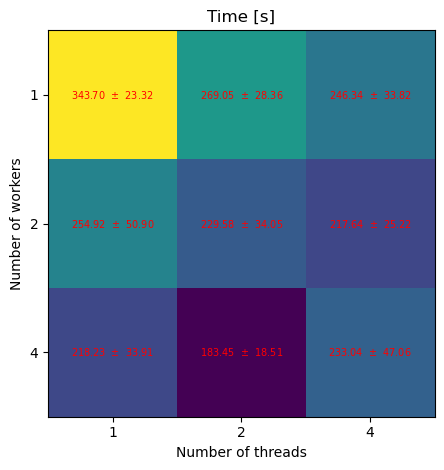

<Figure size 640x480 with 0 Axes>

In [ ]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

# df_cm = pd.DataFrame(mean, index = [str(t) for t in threads_list],
#                   columns = [str(w) for w in workers_list])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

fig, ax = plt.subplots()
im = ax.imshow(mean)

ax.set_xticks(np.arange(len(threads_list)), labels=np.array(threads_list, dtype=str))
ax.set_yticks(np.arange(len(workers_list)), labels=np.array(workers_list, dtype=str))

for w in range(len(workers_list)):
    for t in range(len(threads_list)):
        text = ax.text(t, w, r'%.2f  $\pm$  %.2f' % (mean[w,t], std[w,t]),
                       ha="center", va="center", color="red", fontsize=7)

ax.set_xlabel('Number of threads')
ax.set_ylabel('Number of workers')
ax.set_title('Time [s]')
fig.tight_layout()
plt.figure(figsize=(8, 6), dpi=80)

plt.show()

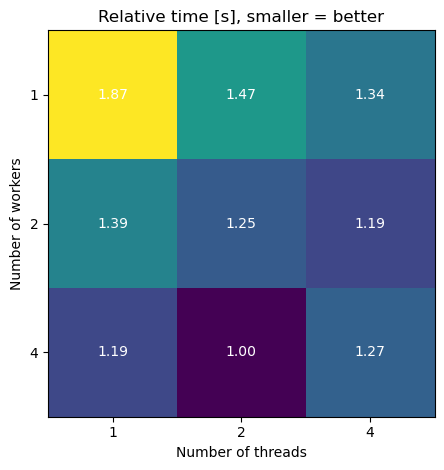

In [ ]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

# df_cm = pd.DataFrame(mean, index = [str(t) for t in threads_list],
#                   columns = [str(w) for w in workers_list])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

fig, ax = plt.subplots()
im = ax.imshow(mean)

ax.set_xticks(np.arange(len(threads_list)), labels=np.array(threads_list, dtype=str))
ax.set_yticks(np.arange(len(workers_list)), labels=np.array(workers_list, dtype=str))

for w in range(len(workers_list)):
    for t in range(len(threads_list)):
        text = ax.text(t, w, '%.2f' %(mean[w,t]/mean.min()),
                       ha="center", va="center", color="w")
ax.set_xlabel('Number of threads')
ax.set_ylabel('Number of workers')
ax.set_title('Relative time [s], smaller = better')
fig.tight_layout()
plt.show()

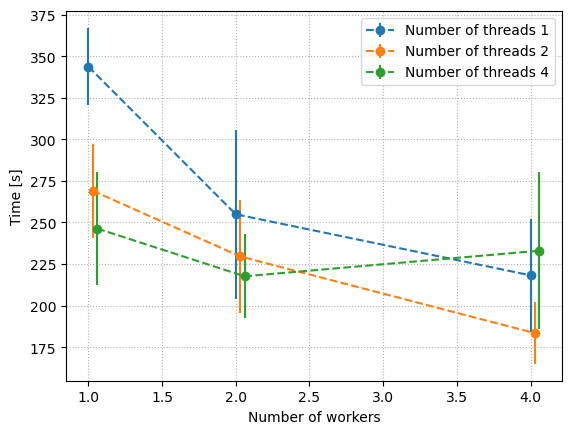

In [ ]:
for k, t in enumerate(threads_list):
    if k == 0:
        plt.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    elif k == 1:
        plt.errorbar(np.array(workers_list)+0.03, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        plt.errorbar(np.array(workers_list)+0.06, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
plt.grid(linestyle='dotted')
plt.ylabel('Time [s]')
plt.xlabel('Number of workers')
plt.legend()


## Seaborn and Dictionary 

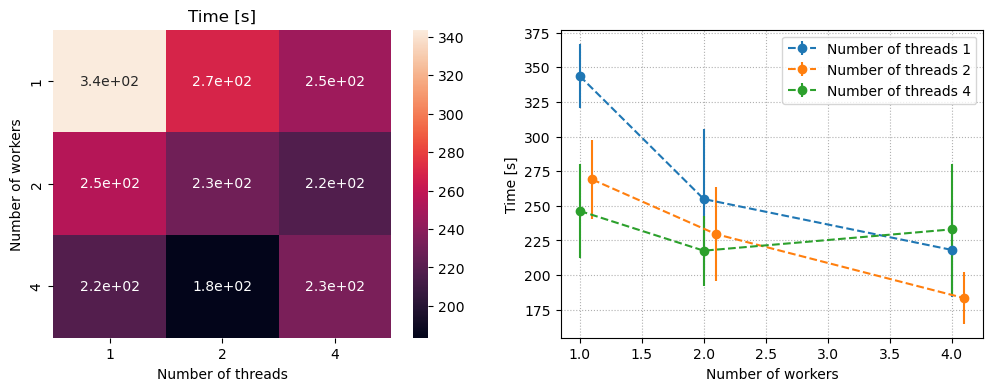

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
array = np.load('Bench_files/Benchmark_Workers_Threads_bag_try.npy')

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

df_cm = pd.DataFrame(mean, index = [str(w) for w in workers_list],
                  columns = [str(t) for t in threads_list])

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(df_cm, annot=True, ax=ax1)
ax1.set_xlabel('Number of threads')
ax1.set_ylabel('Number of workers')
ax1.set_title('Time [s]')

for k, t in enumerate(threads_list):
    if k == 1:
        ax2.errorbar(np.array(workers_list)+0.1, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        ax2.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
ax2.grid(linestyle='dotted')
ax2.set_ylabel('Time [s]')
ax2.set_xlabel('Number of workers')
ax2.legend()


# Benchmar Worker Multiprocessing (poor statistic, no real advantage noticed)

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [2]
time_list = np.zeros(shape=(attempt, len(workers_list), len(threads_list)))

for a in range(attempt):
    for w,_ in enumerate(workers_list):
        for t,_ in enumerate(threads_list):
            print('a:', a, '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
            #cluster up
            cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": workers_list[w],
                            "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
            client=Client(cluster)
            dask.config.set({'distributed.worker.multiprocessing-method': 'spawn'})

            #begin time
            time_i = time.time()
            
            bag=db.from_sequence([
                        [dir_ + f'/0/output_{thread}.csv', 
                         dir_ + f'/0/evolved_{thread}.dat',
                         dir_ + f'/0/logfile_{thread}.dat'] for dir_ in [dir_list[0]] for thread in range(30)])
            
            ## Map the preprocessing function to the bag
            bag_of_df = bag.map(preprocessing_bag_of_thread)
            
            
            bag_of_dicts = bag_of_df.map(lambda df: df.to_dict(orient='records')).flatten()
            bhbh=bag_of_dicts.to_dataframe()#.repartition(npartitions=4)
            bhbh = bhbh.compute()
            
            #end time
            time_f = time.time(
            
            )
            
            #time difference allocation
            time_list[a, w, t] = time_f - time_i

            #cluster down
            cluster.close()
            
#Save the result
np.save('Bench_files/bench_worker_multiprocessing_bag_try.npy', time_list)

a: 0 	 w: 2 	 t: 2


2023-06-16 13:02:03,765 - distributed.deploy.ssh - INFO - 2023-06-16 13:02:03,762 - distributed.scheduler - INFO - State start
2023-06-16 13:02:03,770 - distributed.deploy.ssh - INFO - 2023-06-16 13:02:03,767 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dfdlkbs3', purging
2023-06-16 13:02:03,771 - distributed.deploy.ssh - INFO - 2023-06-16 13:02:03,768 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qrb6fdq3', purging
2023-06-16 13:02:03,773 - distributed.deploy.ssh - INFO - 2023-06-16 13:02:03,771 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2ahiiv4b', purging
2023-06-16 13:02:03,774 - distributed.deploy.ssh - INFO - 2023-06-16 13:02:03,772 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-m4km6cfe', purging
2023-06-16 13:02:03,827 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 w: 2 	 t: 2


2023-06-16 13:07:00,667 - distributed.deploy.ssh - INFO - 2023-06-16 13:07:00,666 - distributed.scheduler - INFO - State start
2023-06-16 13:07:00,696 - distributed.deploy.ssh - INFO - 2023-06-16 13:07:00,694 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-os6l809h', purging
2023-06-16 13:07:00,728 - distributed.deploy.ssh - INFO - 2023-06-16 13:07:00,727 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-eqbsq6w3', purging
2023-06-16 13:07:00,734 - distributed.deploy.ssh - INFO - 2023-06-16 13:07:00,733 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-16 13:07:01,698 - distributed.deploy.ssh - INFO - 2023-06-16 13:07:01,696 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36583'
2023-06-16 13:07:01,710 - distributed.deploy.ssh - INFO - 2023-06-16 13:07:01,709 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 2 	 w: 2 	 t: 2


2023-06-16 13:11:45,973 - distributed.deploy.ssh - INFO - 2023-06-16 13:11:45,971 - distributed.scheduler - INFO - State start
2023-06-16 13:11:45,976 - distributed.deploy.ssh - INFO - 2023-06-16 13:11:45,973 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-vk_p737x', purging
2023-06-16 13:11:45,979 - distributed.deploy.ssh - INFO - 2023-06-16 13:11:45,978 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-diq0_3j8', purging
2023-06-16 13:11:45,989 - distributed.deploy.ssh - INFO - 2023-06-16 13:11:45,988 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-16 13:11:46,892 - distributed.deploy.ssh - INFO - 2023-06-16 13:11:46,890 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42267'
2023-06-16 13:11:46,918 - distributed.deploy.ssh - INFO - 2023-06-16 13:11:46,917 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 3 	 w: 2 	 t: 2


2023-06-16 13:17:24,615 - distributed.deploy.ssh - INFO - 2023-06-16 13:17:24,614 - distributed.scheduler - INFO - State start
2023-06-16 13:17:24,619 - distributed.deploy.ssh - INFO - 2023-06-16 13:17:24,616 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-b094vgzq', purging
2023-06-16 13:17:24,661 - distributed.deploy.ssh - INFO - 2023-06-16 13:17:24,660 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c8edeiop', purging
2023-06-16 13:17:24,667 - distributed.deploy.ssh - INFO - 2023-06-16 13:17:24,667 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-16 13:17:28,130 - distributed.deploy.ssh - INFO - 2023-06-16 13:17:28,129 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42341'
2023-06-16 13:17:28,133 - distributed.deploy.ssh - INFO - 2023-06-16 13:17:28,130 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 4 	 w: 2 	 t: 2


2023-06-16 13:22:51,800 - distributed.deploy.ssh - INFO - 2023-06-16 13:22:51,798 - distributed.scheduler - INFO - State start
2023-06-16 13:22:51,824 - distributed.deploy.ssh - INFO - 2023-06-16 13:22:51,823 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4yl2opvw', purging
2023-06-16 13:22:51,830 - distributed.deploy.ssh - INFO - 2023-06-16 13:22:51,829 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-k93rk1he', purging
2023-06-16 13:22:51,836 - distributed.deploy.ssh - INFO - 2023-06-16 13:22:51,835 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-16 13:22:52,777 - distributed.deploy.ssh - INFO - 2023-06-16 13:22:52,776 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42543'
2023-06-16 13:22:52,796 - distributed.deploy.ssh - INFO - 2023-06-16 13:22:52,796 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

In [ ]:
array = np.load('Bench_files/bench_worker_multiprocessing_bag_try.npy')
array

array([[[281.48210073]],

       [[273.33795404]],

       [[326.99966002]],

       [[313.86417937]],

       [[308.98030305]]])

In [ ]:
mean, std = np.mean(array), np.std(array)

In [ ]:
print(str(mean) + ' +/- ' + str(std), 'vs', '184.45 +/- 18.')

300.93283944129945 +/- 20.254724359731988 vs 184.45 +/- 18.


In [35]:
cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": 1,
                            "nthreads": 1}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
client=Client(cluster)

2023-06-16 20:58:58,778 - distributed.deploy.ssh - INFO - 2023-06-16 20:58:58,776 - distributed.scheduler - INFO - State start
2023-06-16 20:58:58,782 - distributed.deploy.ssh - INFO - 2023-06-16 20:58:58,777 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zvjnwakj', purging
2023-06-16 20:58:58,784 - distributed.deploy.ssh - INFO - 2023-06-16 20:58:58,783 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-16 20:58:59,743 - distributed.deploy.ssh - INFO - 2023-06-16 20:58:59,742 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:38977'
2023-06-16 20:58:59,752 - distributed.deploy.ssh - INFO - 2023-06-16 20:58:59,742 - distributed.nanny - ERROR - Failed to start process
2023-06-16 20:58:59,753 - distributed.deploy.ssh - INFO - Traceback (most recent call last):
2023-06-16 20:58:59,753 - distributed.deploy.ssh - INFO - File "/home/ubuntu/miniconda3/lib/python3.10/site-packages/distrib

AssertionError: Status.created

In [33]:
dask.config.set({'distributed.worker.multiprocessing-method': 'distributed'})

In [34]:
dask.config.get("distributed.worker") 

{'blocked-handlers': [],
 'multiprocessing-method': 'distributed',
 'use-file-locking': True,
 'transfer': {'message-bytes-limit': '50MB'},
 'connections': {'outgoing': 50, 'incoming': 10},
 'preload': [],
 'preload-argv': [],
 'daemon': True,
 'validate': False,
 'resources': {},
 'lifetime': {'duration': None, 'stagger': '0 seconds', 'restart': False},
 'profile': {'enabled': True,
  'interval': '10ms',
  'cycle': '1000ms',
  'low-level': False},
 'memory': {'recent-to-old-time': '30s',
  'rebalance': {'measure': 'optimistic',
   'sender-min': 0.3,
   'recipient-max': 0.6,
   'sender-recipient-gap': 0.1},
  'transfer': 0.1,
  'target': 0.6,
  'spill': 0.7,
  'pause': 0.8,
  'terminate': 0.95,
  'max-spill': False,
  'spill-compression': 'auto',
  'monitor-interval': '100ms'},
 'http': {'routes': ['distributed.http.worker.prometheus',
   'distributed.http.health',
   'distributed.http.statics']}}

# Benchmark with partitions for output (1, 15, 30)

In [7]:
cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": 4,
                                "nthreads": 2}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
client=Client(cluster)

2023-06-17 13:52:16,732 - distributed.deploy.ssh - INFO - 2023-06-17 13:52:16,731 - distributed.scheduler - INFO - State start
2023-06-17 13:52:16,753 - distributed.deploy.ssh - INFO - 2023-06-17 13:52:16,752 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-jsg98ppp', purging
2023-06-17 13:52:16,792 - distributed.deploy.ssh - INFO - 2023-06-17 13:52:16,791 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-uhhag15t', purging
2023-06-17 13:52:16,796 - distributed.deploy.ssh - INFO - 2023-06-17 13:52:16,792 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2zx9swll', purging
2023-06-17 13:52:16,798 - distributed.deploy.ssh - INFO - 2023-06-17 13:52:16,793 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fptvshc_', purging
2023-06-17 13:52:16,800 - distributed.deploy.ssh - INFO - 2023-06

In [8]:
bag=db.from_sequence([
                    [dir_ + f'/0/output_{thread}.csv', 
                     dir_ + f'/0/evolved_{thread}.dat',
                     dir_ + f'/0/logfile_{thread}.dat'] for dir_ in [dir_list[0]] for thread in range(30)])


In [9]:
bag.npartitions

30

In [ ]:
attempt = 10
workers_list = [4]
threads_list = [2]
partitions_list = [15, 30, 45]
time_list = np.zeros(shape=(attempt, len(partitions_list), len(workers_list), len(threads_list)))


for a in range(attempt):
    for d in range(len(partitions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                print('a:', a, '\t','d:', partitions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
                #cluster up
                cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": workers_list[w],
                                "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
                client=Client(cluster)

                #begin time
                time_i = time.time()

                #bag  
                bag=db.from_sequence([
                            [dir_ + f'/0/output_{thread}.csv', 
                             dir_ + f'/0/evolved_{thread}.dat',
                             dir_ + f'/0/logfile_{thread}.dat'] for dir_ in [dir_list[0]] for thread in range(30)], npartitions=partitions_list[d])

                ## Map the preprocessing function to the bag
                bag_of_df = bag.map(preprocessing_bag_of_thread)


                bag_of_dicts = bag_of_df.map(lambda df: df.to_dict(orient='records')).flatten()
                bhbh=bag_of_dicts.to_dataframe()#.repartition(npartitions=4)
                bhbh = bhbh.compute()

                #end time
                time_f = time.time()

                #time difference allocation
                time_list[a, d, w, t] = time_f - time_i

                #cluster down
                cluster.close()

#Save the result
np.save('Bench_files_10/Benchmark_divisions_bag_try_10.npy', time_list)

a: 0 	 d: 15 	 w: 4 	 t: 2


2023-06-17 13:54:25,339 - distributed.deploy.ssh - INFO - 2023-06-17 13:54:25,337 - distributed.scheduler - INFO - State start
2023-06-17 13:54:25,342 - distributed.deploy.ssh - INFO - 2023-06-17 13:54:25,341 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-suz8p09n', purging
2023-06-17 13:54:25,344 - distributed.deploy.ssh - INFO - 2023-06-17 13:54:25,342 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-017i0na4', purging
2023-06-17 13:54:25,347 - distributed.deploy.ssh - INFO - 2023-06-17 13:54:25,343 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-sa3_0c5w', purging
2023-06-17 13:54:25,348 - distributed.deploy.ssh - INFO - 2023-06-17 13:54:25,344 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_vk96chk', purging
2023-06-17 13:54:25,352 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 30 	 w: 4 	 t: 2


2023-06-17 13:58:06,106 - distributed.deploy.ssh - INFO - 2023-06-17 13:58:06,105 - distributed.scheduler - INFO - State start
2023-06-17 13:58:06,110 - distributed.deploy.ssh - INFO - 2023-06-17 13:58:06,107 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9g8vv7o6', purging
2023-06-17 13:58:06,110 - distributed.deploy.ssh - INFO - 2023-06-17 13:58:06,108 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s21wcba2', purging
2023-06-17 13:58:06,113 - distributed.deploy.ssh - INFO - 2023-06-17 13:58:06,108 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-al93g1e6', purging
2023-06-17 13:58:06,114 - distributed.deploy.ssh - INFO - 2023-06-17 13:58:06,110 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-jhyg1_is', purging
2023-06-17 13:58:06,124 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 45 	 w: 4 	 t: 2


2023-06-17 14:02:33,462 - distributed.deploy.ssh - INFO - 2023-06-17 14:02:33,461 - distributed.scheduler - INFO - State start
2023-06-17 14:02:33,478 - distributed.deploy.ssh - INFO - 2023-06-17 14:02:33,472 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-44za20mu', purging
2023-06-17 14:02:33,508 - distributed.deploy.ssh - INFO - 2023-06-17 14:02:33,507 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c4gluz78', purging
2023-06-17 14:02:33,515 - distributed.deploy.ssh - INFO - 2023-06-17 14:02:33,514 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q5ldrp0k', purging
2023-06-17 14:02:33,519 - distributed.deploy.ssh - INFO - 2023-06-17 14:02:33,519 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q5v23ia7', purging
2023-06-17 14:02:33,528 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 15 	 w: 4 	 t: 2


2023-06-17 14:05:45,222 - distributed.deploy.ssh - INFO - 2023-06-17 14:05:45,220 - distributed.scheduler - INFO - State start
2023-06-17 14:05:45,262 - distributed.deploy.ssh - INFO - 2023-06-17 14:05:45,260 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l3nxeqr2', purging
2023-06-17 14:05:45,271 - distributed.deploy.ssh - INFO - 2023-06-17 14:05:45,271 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-5333u75q', purging
2023-06-17 14:05:45,274 - distributed.deploy.ssh - INFO - 2023-06-17 14:05:45,273 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ez5ppjb6', purging
2023-06-17 14:05:45,276 - distributed.deploy.ssh - INFO - 2023-06-17 14:05:45,274 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-wehjnq55', purging
2023-06-17 14:05:45,284 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 30 	 w: 4 	 t: 2


2023-06-17 14:09:08,273 - distributed.deploy.ssh - INFO - 2023-06-17 14:09:08,272 - distributed.scheduler - INFO - State start
2023-06-17 14:09:08,277 - distributed.deploy.ssh - INFO - 2023-06-17 14:09:08,274 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zdilnhk9', purging
2023-06-17 14:09:08,278 - distributed.deploy.ssh - INFO - 2023-06-17 14:09:08,274 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7kenwtl0', purging
2023-06-17 14:09:08,278 - distributed.deploy.ssh - INFO - 2023-06-17 14:09:08,275 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-wzk8g8az', purging
2023-06-17 14:09:08,281 - distributed.deploy.ssh - INFO - 2023-06-17 14:09:08,275 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1zxha26f', purging
2023-06-17 14:09:08,283 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 45 	 w: 4 	 t: 2


2023-06-17 14:13:37,253 - distributed.deploy.ssh - INFO - 2023-06-17 14:13:37,252 - distributed.scheduler - INFO - State start
2023-06-17 14:13:37,263 - distributed.deploy.ssh - INFO - 2023-06-17 14:13:37,262 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xfl7mea1', purging
2023-06-17 14:13:37,275 - distributed.deploy.ssh - INFO - 2023-06-17 14:13:37,274 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c51i8qgf', purging
2023-06-17 14:13:37,281 - distributed.deploy.ssh - INFO - 2023-06-17 14:13:37,280 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-v6wdrv6q', purging
2023-06-17 14:13:37,282 - distributed.deploy.ssh - INFO - 2023-06-17 14:13:37,281 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-g6ya_oac', purging
2023-06-17 14:13:37,288 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 15 	 w: 4 	 t: 2


2023-06-17 14:17:51,437 - distributed.deploy.ssh - INFO - 2023-06-17 14:17:51,435 - distributed.scheduler - INFO - State start
2023-06-17 14:17:51,497 - distributed.deploy.ssh - INFO - 2023-06-17 14:17:51,496 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-abv9pr05', purging
2023-06-17 14:17:51,505 - distributed.deploy.ssh - INFO - 2023-06-17 14:17:51,504 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-lzr20chn', purging
2023-06-17 14:17:51,511 - distributed.deploy.ssh - INFO - 2023-06-17 14:17:51,510 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4nxfaybq', purging
2023-06-17 14:17:51,515 - distributed.deploy.ssh - INFO - 2023-06-17 14:17:51,514 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-72iwm4tp', purging
2023-06-17 14:17:51,522 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 30 	 w: 4 	 t: 2


2023-06-17 14:21:49,755 - distributed.deploy.ssh - INFO - 2023-06-17 14:21:49,753 - distributed.scheduler - INFO - State start
2023-06-17 14:21:49,800 - distributed.deploy.ssh - INFO - 2023-06-17 14:21:49,799 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-tpjx7qhh', purging
2023-06-17 14:21:49,802 - distributed.deploy.ssh - INFO - 2023-06-17 14:21:49,800 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2wf7rz2g', purging
2023-06-17 14:21:49,803 - distributed.deploy.ssh - INFO - 2023-06-17 14:21:49,800 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-jlhu5745', purging
2023-06-17 14:21:49,806 - distributed.deploy.ssh - INFO - 2023-06-17 14:21:49,802 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-menhodqm', purging
2023-06-17 14:21:49,812 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 45 	 w: 4 	 t: 2


2023-06-17 14:26:45,618 - distributed.deploy.ssh - INFO - 2023-06-17 14:26:45,616 - distributed.scheduler - INFO - State start
2023-06-17 14:26:45,636 - distributed.deploy.ssh - INFO - 2023-06-17 14:26:45,618 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-__1rybit', purging
2023-06-17 14:26:45,637 - distributed.deploy.ssh - INFO - 2023-06-17 14:26:45,625 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ozlh721m', purging
2023-06-17 14:26:45,638 - distributed.deploy.ssh - INFO - 2023-06-17 14:26:45,630 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q1zz1aqk', purging
2023-06-17 14:26:45,639 - distributed.deploy.ssh - INFO - 2023-06-17 14:26:45,632 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-d_vmgxuj', purging
2023-06-17 14:26:45,644 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 15 	 w: 4 	 t: 2


2023-06-17 14:31:16,816 - distributed.deploy.ssh - INFO - 2023-06-17 14:31:16,815 - distributed.scheduler - INFO - State start
2023-06-17 14:31:16,819 - distributed.deploy.ssh - INFO - 2023-06-17 14:31:16,817 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hc13kn5x', purging
2023-06-17 14:31:16,878 - distributed.deploy.ssh - INFO - 2023-06-17 14:31:16,877 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-r1apzxx7', purging
2023-06-17 14:31:16,881 - distributed.deploy.ssh - INFO - 2023-06-17 14:31:16,881 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-w55v5bd4', purging
2023-06-17 14:31:16,887 - distributed.deploy.ssh - INFO - 2023-06-17 14:31:16,886 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_lpvh2mr', purging
2023-06-17 14:31:16,899 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 30 	 w: 4 	 t: 2


2023-06-17 14:35:12,197 - distributed.deploy.ssh - INFO - 2023-06-17 14:35:12,196 - distributed.scheduler - INFO - State start
2023-06-17 14:35:12,203 - distributed.deploy.ssh - INFO - 2023-06-17 14:35:12,198 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0uy5se6g', purging
2023-06-17 14:35:12,206 - distributed.deploy.ssh - INFO - 2023-06-17 14:35:12,198 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qlpmnahn', purging
2023-06-17 14:35:12,210 - distributed.deploy.ssh - INFO - 2023-06-17 14:35:12,199 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ls_m250o', purging
2023-06-17 14:35:12,211 - distributed.deploy.ssh - INFO - 2023-06-17 14:35:12,200 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4rzgenb5', purging
2023-06-17 14:35:12,213 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 45 	 w: 4 	 t: 2


2023-06-17 14:39:28,447 - distributed.deploy.ssh - INFO - 2023-06-17 14:39:28,446 - distributed.scheduler - INFO - State start
2023-06-17 14:39:28,458 - distributed.deploy.ssh - INFO - 2023-06-17 14:39:28,457 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-cbjar7us', purging
2023-06-17 14:39:28,487 - distributed.deploy.ssh - INFO - 2023-06-17 14:39:28,486 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yis404tf', purging
2023-06-17 14:39:28,489 - distributed.deploy.ssh - INFO - 2023-06-17 14:39:28,488 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-pr15bn3d', purging
2023-06-17 14:39:28,491 - distributed.deploy.ssh - INFO - 2023-06-17 14:39:28,490 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h0bd7k3h', purging
2023-06-17 14:39:28,497 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 15 	 w: 4 	 t: 2


2023-06-17 14:43:33,853 - distributed.deploy.ssh - INFO - 2023-06-17 14:43:33,852 - distributed.scheduler - INFO - State start
2023-06-17 14:43:33,858 - distributed.deploy.ssh - INFO - 2023-06-17 14:43:33,857 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gaku9r8_', purging
2023-06-17 14:43:33,895 - distributed.deploy.ssh - INFO - 2023-06-17 14:43:33,894 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qtp6qfqu', purging
2023-06-17 14:43:33,899 - distributed.deploy.ssh - INFO - 2023-06-17 14:43:33,899 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q46e88ik', purging
2023-06-17 14:43:33,905 - distributed.deploy.ssh - INFO - 2023-06-17 14:43:33,904 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ci1a7jxe', purging
2023-06-17 14:43:33,912 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 30 	 w: 4 	 t: 2


2023-06-17 14:47:10,412 - distributed.deploy.ssh - INFO - 2023-06-17 14:47:10,410 - distributed.scheduler - INFO - State start
2023-06-17 14:47:10,416 - distributed.deploy.ssh - INFO - 2023-06-17 14:47:10,412 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qy44lbew', purging
2023-06-17 14:47:10,417 - distributed.deploy.ssh - INFO - 2023-06-17 14:47:10,413 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2latp3tl', purging
2023-06-17 14:47:10,417 - distributed.deploy.ssh - INFO - 2023-06-17 14:47:10,414 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-tfi87076', purging
2023-06-17 14:47:10,420 - distributed.deploy.ssh - INFO - 2023-06-17 14:47:10,414 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-twvizefy', purging
2023-06-17 14:47:10,424 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 45 	 w: 4 	 t: 2


2023-06-17 14:51:28,757 - distributed.deploy.ssh - INFO - 2023-06-17 14:51:28,756 - distributed.scheduler - INFO - State start
2023-06-17 14:51:28,766 - distributed.deploy.ssh - INFO - 2023-06-17 14:51:28,764 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-usg1q_65', purging
2023-06-17 14:51:28,812 - distributed.deploy.ssh - INFO - 2023-06-17 14:51:28,810 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qtn7x1f2', purging
2023-06-17 14:51:28,822 - distributed.deploy.ssh - INFO - 2023-06-17 14:51:28,821 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xcjw7ev2', purging
2023-06-17 14:51:28,827 - distributed.deploy.ssh - INFO - 2023-06-17 14:51:28,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p5dulbt1', purging
2023-06-17 14:51:28,837 - distributed.deploy.ssh - INFO - 2023-06

a: 5 	 d: 15 	 w: 4 	 t: 2


2023-06-17 14:55:16,188 - distributed.deploy.ssh - INFO - 2023-06-17 14:55:16,186 - distributed.scheduler - INFO - State start
2023-06-17 14:55:16,195 - distributed.deploy.ssh - INFO - 2023-06-17 14:55:16,194 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6erb9yfz', purging
2023-06-17 14:55:16,244 - distributed.deploy.ssh - INFO - 2023-06-17 14:55:16,242 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-kdz7v5ep', purging
2023-06-17 14:55:16,249 - distributed.deploy.ssh - INFO - 2023-06-17 14:55:16,248 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gt8r9jj_', purging
2023-06-17 14:55:16,251 - distributed.deploy.ssh - INFO - 2023-06-17 14:55:16,250 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-aiu_uwij', purging
2023-06-17 14:55:16,259 - distributed.deploy.ssh - INFO - 2023-06

a: 5 	 d: 30 	 w: 4 	 t: 2


2023-06-17 14:58:46,085 - distributed.deploy.ssh - INFO - 2023-06-17 14:58:46,083 - distributed.scheduler - INFO - State start
2023-06-17 14:58:46,088 - distributed.deploy.ssh - INFO - 2023-06-17 14:58:46,085 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-tchmn1t2', purging
2023-06-17 14:58:46,091 - distributed.deploy.ssh - INFO - 2023-06-17 14:58:46,088 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-u2764era', purging
2023-06-17 14:58:46,093 - distributed.deploy.ssh - INFO - 2023-06-17 14:58:46,088 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4dcqoz__', purging
2023-06-17 14:58:46,094 - distributed.deploy.ssh - INFO - 2023-06-17 14:58:46,090 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-kux7kp5c', purging
2023-06-17 14:58:46,098 - distributed.deploy.ssh - INFO - 2023-06

## Plot Benchmark partitions

d_1     175.983450
d_2     221.797806
d_12    241.021792
dtype: float64
d_1     13.033073
d_2     22.764691
d_12    22.366035
dtype: float64


Text(0.5, 1.0, 'Benchmark divisions')

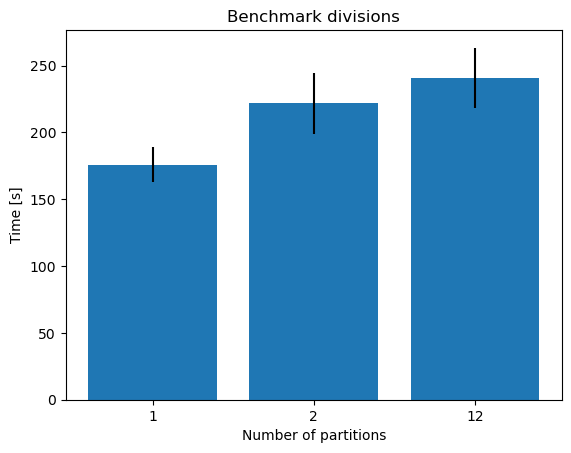

In [ ]:
workers_list = [2]
threads_list = [2]
partitions_list = [1, 15, 30] #to br change in the plot in [1,12,24]
array = np.load('Benchmark_divisions.npy')

mean = np.mean(array, axis = 0)
std = np.std(array, axis = 0)

array = array.reshape((5, 3))
df = pd.DataFrame(array, columns=['d_1', 'd_2', 'd_12'])
print(df.mean(axis=0))
print(df.std(axis=0))

fig,ax = plt.subplots()
ax.bar(x=['1', '2', '12'], height=df.mean(axis=0), yerr=df.std(axis=0))
ax.set_xlabel('Number of partitions')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark divisions')

# Benchmark number of directory 

In [ ]:
number_directory_list = [1,2,3,4]
for n in range(len(number_directory_list)):
    for dir_ in [dir_list[:number_directory_list[n]]]:
        print(n, dir_, '\n')

0 ['/mnt/bhbh/fiducial_Hrad_5M/sevn_output_Z0.0004A1L1'] 

1 ['/mnt/bhbh/fiducial_Hrad_5M/sevn_output_Z0.0004A1L1', '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_Z0.002A0.5L1'] 

2 ['/mnt/bhbh/fiducial_Hrad_5M/sevn_output_Z0.0004A1L1', '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_Z0.002A0.5L1', '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_Z0.02A3L1'] 

3 ['/mnt/bhbh/fiducial_Hrad_5M/sevn_output_Z0.0004A1L1', '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_Z0.002A0.5L1', '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_Z0.02A3L1', '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_Z0.0001A5L1'] 



In [ ]:
attempt = 10
workers_list = [4]
threads_list = [2]
divisions_list = [30] #to be defined
number_directory_list = [1,2,3,4]

time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list), len(number_directory_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                for n in range(len(number_directory_list)):
                    print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t],
                         '\t','n:', number_directory_list[n])

                    #cluster up
                    cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": workers_list[w],
                                    "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
                    client=Client(cluster)

                    #begin time
                    time_i = time.time()

                    #bag  
                    bag=db.from_sequence([
                                [dir_ + f'/0/output_{thread}.csv', 
                                 dir_ + f'/0/evolved_{thread}.dat',
                                 dir_ + f'/0/logfile_{thread}.dat'] for dir_ in dir_list[:number_directory_list[n]] for thread in range(30)], npartitions=partitions_list[d]*number_directory_list[n])

                    ## Map the preprocessing function to the bag
                    bag_of_df = bag.map(preprocessing_bag_of_thread)


                    bag_of_dicts = bag_of_df.map(lambda df: df.to_dict(orient='records')).flatten()
                    bhbh=bag_of_dicts.to_dataframe()#.repartition(npartitions=4)
                    bhbh = bhbh.compute()

                    #end time
                    time_f = time.time()

                    #time difference allocation
                    time_list[a, d, w, t, n] = time_f - time_i

                    #cluster down
                    cluster.close()

            
#Save the result
np.save('Bench_files_10/Benchmark_directory_bag_try_10.npy', time_list)

# Benchmark read_time sync

In [ ]:
cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
client=Client(cluster)

2023-06-10 16:21:37,120 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:37,119 - distributed.scheduler - INFO - State start
2023-06-10 16:21:37,151 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:37,150 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-10 16:21:38,165 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,164 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42467'
2023-06-10 16:21:38,176 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,174 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42371'
2023-06-10 16:21:38,186 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,182 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38239'
2023-06-10 16:21:38,199 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,198 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35007'
2023-06-10 16:21:39,074 - distributed.deploy.ssh - INFO - 2023-06-10

In [ ]:
output = dd.read_csv(dir_list[0]+'/0/output_*.csv')
output.columns

Index(['ID', 'name', 'Mass_0', 'MHE_0', 'MCO_0', 'Radius_0', 'RHE_0', 'RCO_0',
       'Luminosity_0', 'Temperature_0', 'Lambda_0', 'Phase_0', 'PhaseBSE_0',
       'RemnantType_0', 'Zams_0', 'Mass_1', 'MHE_1', 'MCO_1', 'Radius_1',
       'RHE_1', 'RCO_1', 'Luminosity_1', 'Temperature_1', 'Lambda_1',
       'Phase_1', 'PhaseBSE_1', 'RemnantType_1', 'Zams_1', 'Semimajor',
       'Eccentricity', 'GWtime', 'BWorldtime', 'BEvent'],
      dtype='object')

In [ ]:
%%time
mean_output = output['name'].count()
mean = dask.compute(mean_output)

CPU times: user 662 ms, sys: 120 ms, total: 782 ms
Wall time: 3min 42s


# Benchmark Grid search (Thread, workers, partitions)

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
divisions_list = [1, 12, 24]
time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])

                #cluster up
                cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": workers_list[w],
                                "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
                client=Client(cluster)

                #begin time
                time_i = time.time()

                #function loop
                n_threads_DEMO = 30
                bhbh_list=[]
                for dir_name in dir_list[:1]:
                    for i in range(n_threads_DEMO):
                        _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                          drop_list, n_part=divisions_list[d])
                        bhbh_list.append(_)

                results = dask.compute(*bhbh_list) 
                results= dask.compute(*results)

                #end time
                time_f = time.time()

                #time difference allocation
                time_list[a, d, w, t] = time_f - time_i

                #cluster down
                cluster.close()
            
#Save the result
np.save('Benchmark_GridSearch.npy', time_list)